# **LIBRARIES**

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
                             cohen_kappa_score)

from scipy.stats import f_oneway, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# **DATA OVERVIEW**

In [2]:
df_raw = pd.read_csv('/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')
df = df_raw.copy()
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [3]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


In [4]:
df.describe(include='O').T

,count,unique,top,freq
Gender,27901,2,Male,15547
City,27901,52,Kalyan,1570
Profession,27901,14,Student,27870
Sleep Duration,27901,5,Less than 5 hours,8310
Dietary Habits,27901,4,Unhealthy,10317
Degree,27901,28,Class 12,6080
Have you ever had suicidal thoughts ?,27901,2,Yes,17656
Family History of Mental Illness,27901,2,No,14398


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

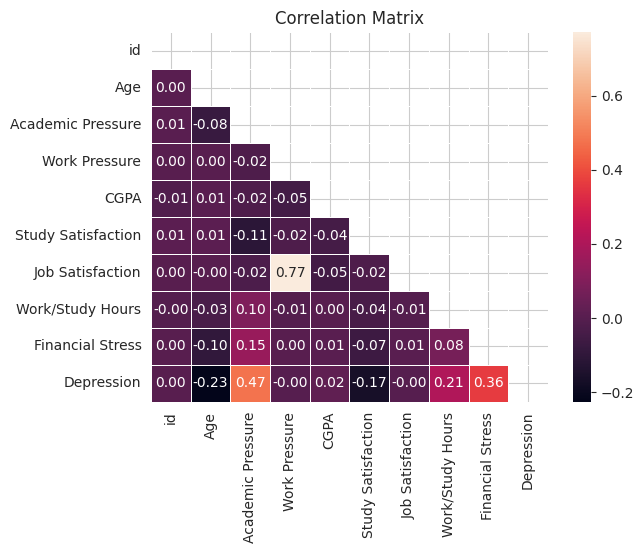

In [6]:
corr_matrix = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## **Data Visualizations**

In [7]:
def create_plots(feature: str, target: str):
    """
    Generates visualizations for the given categorical feature and target variable.
    """
    if feature == "City":
        fig, axes = plt.subplots(3, 1, figsize=(8, 12))  
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
    
    sns.barplot(
        x=feature, 
        y=target, 
        data=df.groupby(feature)[target].count().reset_index().sort_values(by=target, 
                                                                           ascending=False),
        palette='viridis', 
        width=0.6,
        ax=axes[0]
    )
    axes[0].set_title(f'Number of observations in each {feature} category', fontsize=10)
    
    sns.countplot(
        x=feature, 
        hue=target, 
        data=df, 
        palette='viridis', 
        ax=axes[1]
    )
    axes[1].set_title(f'Number of observations in each {feature} category' \
                      f'by {target} status', fontsize=10)

    sns.barplot(
        x=feature, 
        y=target, 
        data=df.groupby(feature)[target].mean().reset_index().sort_values(by=target, 
                                                                          ascending=False),
        palette='viridis', 
        width=0.6,
        ax=axes[2]
    )
    axes[2].set_title(f'Average {target} rate in each {feature} category', fontsize=10)

    if feature in ("Degree", "Sleep Duration", "City"):
        for ax in axes:
            ax.tick_params(axis='x', rotation=90, labelsize=8)

    plt.tight_layout()
    plt.show()

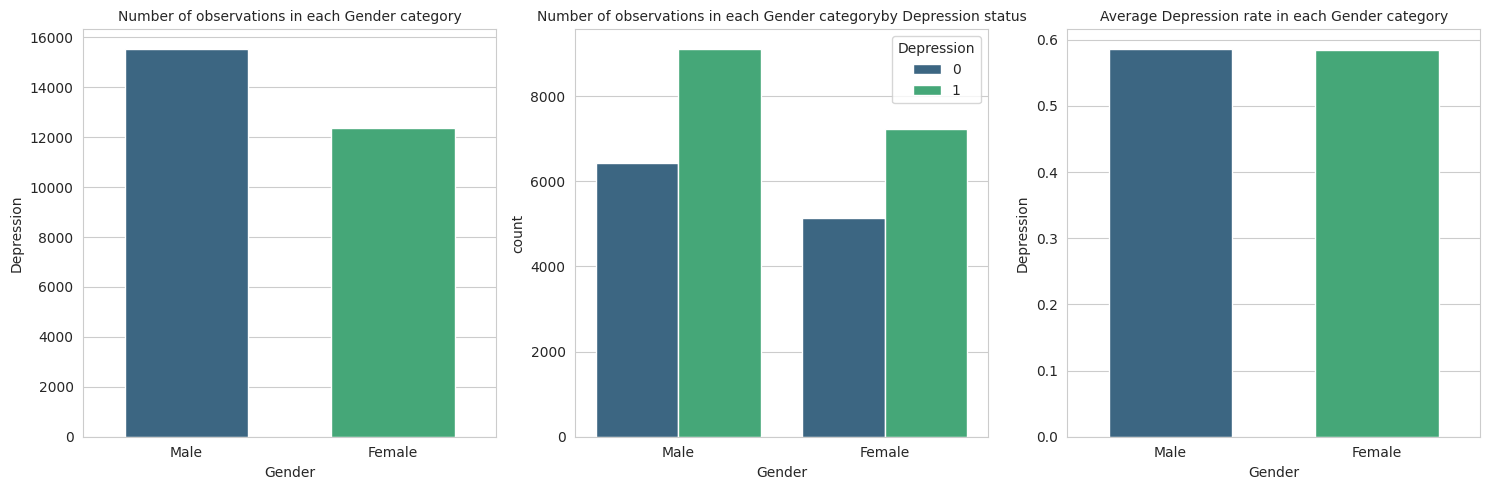

In [8]:
create_plots(feature='Gender', target='Depression')

Despite the differences in group sizes, the average number of people with depression is the same for both groups, which suggests that this feature may not have a significant impact on the model's ability to differentiate between them

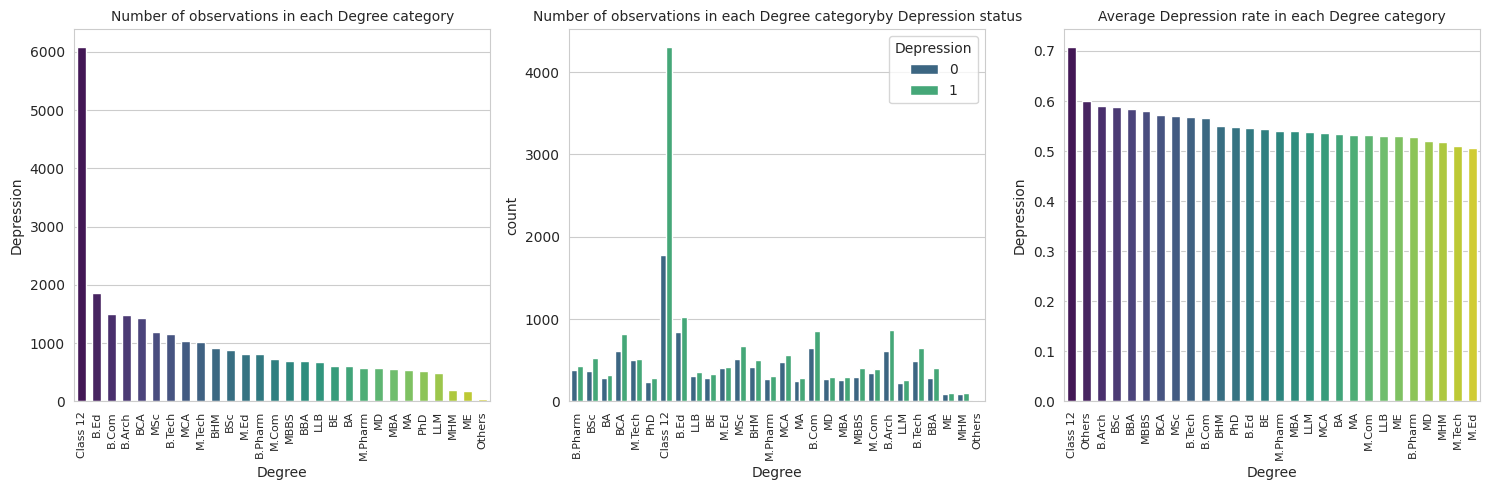

In [9]:
create_plots(feature='Degree', target='Depression')

There is a significant predominance of individuals whose education level is Class 12. More than half of them suffer from depression, a pattern observed only in this group.

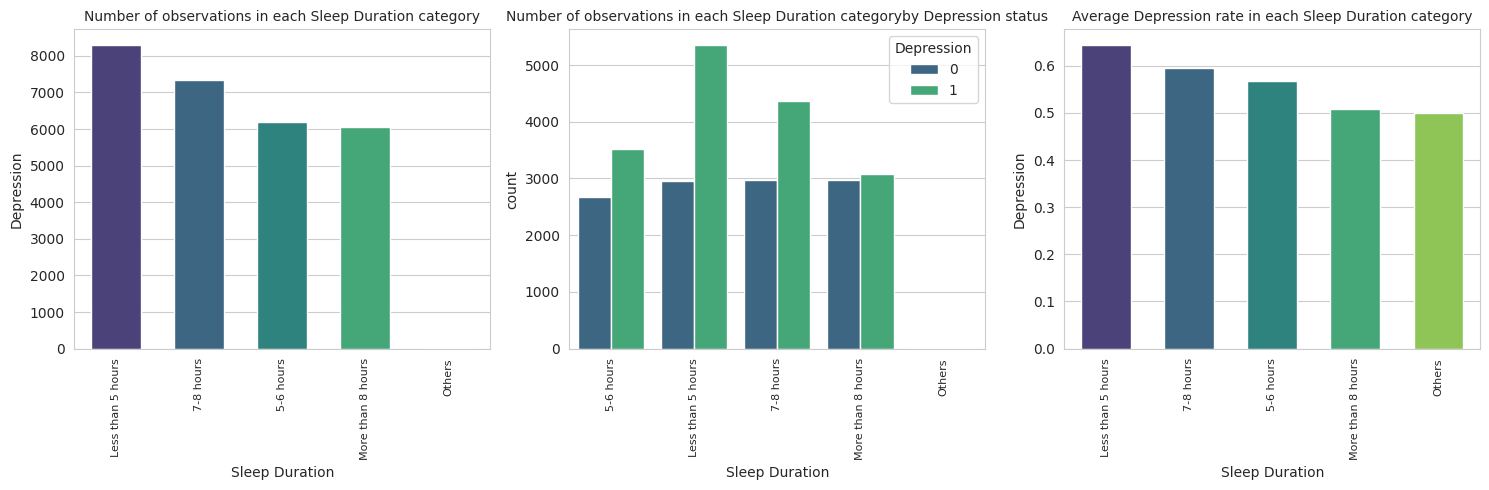

In [10]:
create_plots(feature='Sleep Duration', target='Depression')

We can observe that individuals who sleep less than 5 hours tend to have a higher likelihood of depression, with around half of them being affected.

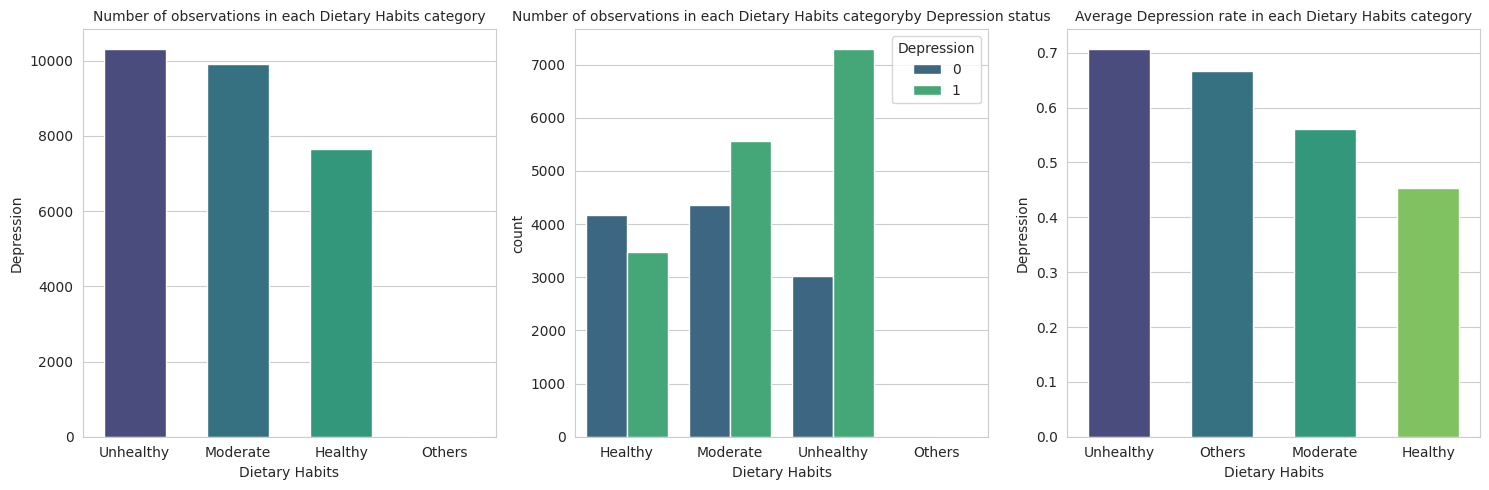

In [11]:
create_plots(feature='Dietary Habits', target='Depression')

Here, we can see that individuals with an unhealthy diet have a significantly higher tendency toward depression—more than twice as many of them are affected.

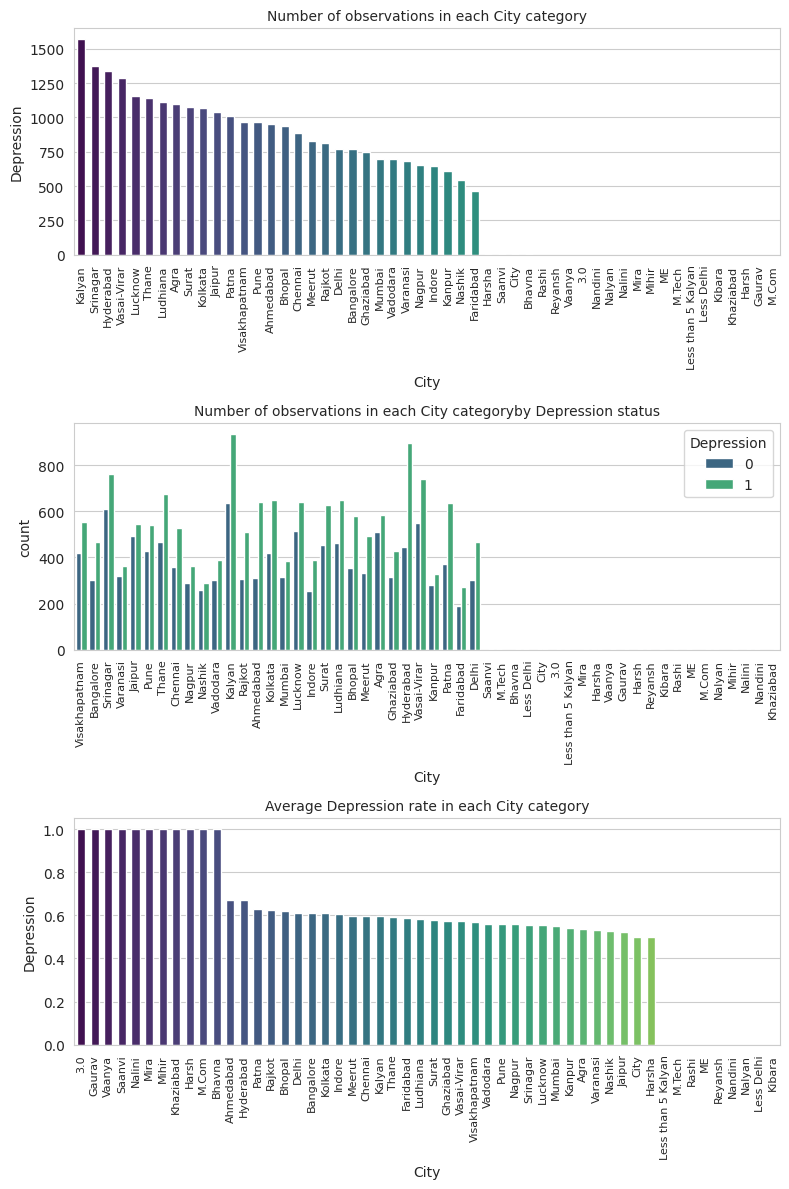

In [12]:
create_plots(feature='City', target='Depression')

There are many inconsistencies in the data, which we will address in the following steps.

## **Data Cleaning**

In [13]:
# rename columns
df = df.rename(columns={
    'Have you ever had suicidal thoughts ?': 'suicidal_thoughts',
    'Family History of Mental Illness': 'family_mental_illness'
})
df.columns = [col.lower().replace(' ', '_').replace('/', '_') for col in df.columns]
df.columns

Index(['id', 'gender', 'age', 'city', 'profession', 'academic_pressure',
       'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction',
       'sleep_duration', 'dietary_habits', 'degree', 'suicidal_thoughts',
       'work_study_hours', 'financial_stress', 'family_mental_illness',
       'depression'],
      dtype='object')

In [14]:
# check for NaN values
df.isna().sum()

id                       0
gender                   0
age                      0
city                     0
profession               0
academic_pressure        0
work_pressure            0
cgpa                     0
study_satisfaction       0
job_satisfaction         0
sleep_duration           0
dietary_habits           0
degree                   0
suicidal_thoughts        0
work_study_hours         0
financial_stress         3
family_mental_illness    0
depression               0
dtype: int64

In [15]:
print(f'NaN values make up {round((df.isna().sum().sum()/len(df))*100, 3)}%' \
       ' of the entire dataset, so we can remove them.')

NaN values make up 0.011% of the entire dataset, so we can remove them.


In [16]:
# remove rows with NaN
df.dropna(inplace=True)

# remove `id` column since it is a unique identifier
df.drop('id', axis=1, inplace=True)

In [17]:
# check for outliers in the 'age' column
df['age'].value_counts()

age
24.0    2258
20.0    2236
28.0    2133
29.0    1949
33.0    1893
25.0    1784
21.0    1726
23.0    1645
18.0    1587
19.0    1560
34.0    1468
27.0    1462
31.0    1427
32.0    1261
22.0    1160
26.0    1155
30.0    1145
35.0      10
38.0       8
36.0       7
42.0       4
48.0       3
39.0       3
43.0       2
46.0       2
37.0       2
49.0       1
51.0       1
44.0       1
59.0       1
54.0       1
58.0       1
56.0       1
41.0       1
Name: count, dtype: int64

In [18]:
# delete the outliers
df = df[df['age'] < 35.0]

In [19]:
# remove the 'profession' column
df.drop('profession', axis=1, inplace=True)

In [20]:
# check for outliers in the 'academic_pressure' column
df['academic_pressure'].value_counts()

academic_pressure
3.0    7450
5.0    6281
4.0    5151
1.0    4787
2.0    4173
0.0       7
Name: count, dtype: int64

In [21]:
# delete the outliers
df = df[df['academic_pressure'] != 0]

In [22]:
# check for outliers in the 'work_pressure' column
df['work_pressure'].value_counts()

work_pressure
0.0    27842
Name: count, dtype: int64

In [23]:
# remove the 'work_pressure' column
df.drop('work_pressure', axis=1, inplace=True)

In [24]:
# check for outliers in the 'cgpa' column
df['cgpa'].value_counts().sort_index()

cgpa
0.00       3
5.03      17
5.06      15
5.08      95
5.09      20
        ... 
9.95     133
9.96     424
9.97     139
9.98      59
10.00     58
Name: count, Length: 331, dtype: int64

In [25]:
# delete the outliers
df = df[df['cgpa'] != 0]

In [26]:
# check for outliers in the 'study_satisfaction' column
df['study_satisfaction'].value_counts()

study_satisfaction
4.0    6350
2.0    5831
3.0    5807
1.0    5438
5.0    4411
0.0       2
Name: count, dtype: int64

In [27]:
# delete the outliers
df = df[df['study_satisfaction'] != 0]

In [28]:
# check for outliers in the 'job_satisfaction' column
df['job_satisfaction'].value_counts()

job_satisfaction
0.0    27835
3.0        1
2.0        1
Name: count, dtype: int64

In [29]:
# remove the 'job_satisfaction' column
df.drop('job_satisfaction', axis=1, inplace=True)

In [30]:
# check for outliers in the 'sleep_duration' column
df['sleep_duration'].value_counts()

sleep_duration
Less than 5 hours    8292
7-8 hours            7332
5-6 hours            6162
More than 8 hours    6033
Others                 18
Name: count, dtype: int64

In [31]:
# delete the outliers
df = df[df['sleep_duration'] != 'Others']

In [32]:
# check for outliers in the 'dietary_habits' column
df['dietary_habits'].value_counts()

dietary_habits
Unhealthy    10291
Moderate      9885
Healthy       7631
Others          12
Name: count, dtype: int64

In [33]:
# delete the outliers
df = df[df['dietary_habits'] != 'Others']

In [34]:
# check for outliers in the 'degree' column
df['degree'].value_counts()

degree
Class 12    6059
B.Ed        1862
B.Com       1501
B.Arch      1474
BCA         1431
MSc         1187
B.Tech      1151
MCA         1037
M.Tech      1019
BHM          924
BSc          882
M.Ed         816
B.Pharm      809
M.Com        731
BBA          695
MBBS         690
LLB          669
BE           611
BA           597
M.Pharm      580
MD           570
MBA          561
MA           544
PhD          515
LLM          482
MHM          191
ME           184
Others        35
Name: count, dtype: int64

In [35]:
# delete the outliers
df = df[df['degree'] != 'Others']

In [36]:
# check for outliers in the 'work_study_hours' column
df['work_study_hours'].value_counts()

work_study_hours
10.0    4221
12.0    3157
11.0    2884
8.0     2502
6.0     2242
9.0     2015
7.0     1993
0.0     1689
4.0     1603
2.0     1576
3.0     1460
5.0     1288
1.0     1142
Name: count, dtype: int64

In [37]:
# check for outliers in the 'financial_stress' column
df['financial_stress'].value_counts()

financial_stress
5.0    6683
4.0    5743
3.0    5203
1.0    5098
2.0    5045
Name: count, dtype: int64

## **Feature Engineering**

### **Utils**

In [38]:
def chi_test_results(feature: str):
    contingency_table = pd.crosstab(df[feature], df['depression'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square p-value: {p}")
    print("Is there a statistically significant relationship between the variables? " \
          f"{'yes' if p <= 0.05 else 'no'}")


def anova_test_results(feature: str):
    groups = [group['depression'].values for _, group in df.groupby(feature)]
    stat, p_value = f_oneway(*groups)
    print(f"ANOVA p-value: {p_value}")
    print("Is there a statistically significant difference between the groups? " \
          f"{'yes' if p_value <= 0.05 else 'no'}")

------------------------------------------------------------------------------------

In [39]:
# find columns with ('Yes', 'No') object data type
yes_no_columns = [col for col in df.columns if df[col].isin(['Yes', 'No']).any()]
print(f"Columns containing 'Yes' and 'No' values:", *yes_no_columns)

# change ('Yes', 'No') object values to (1, 0) integer
df[yes_no_columns] = df[yes_no_columns].map(
    lambda x: 1 if x == 'Yes' else 0
)

Columns containing 'Yes' and 'No' values: suicidal_thoughts family_mental_illness


### **Optimal Binning for City Feature**

#### **I. City Feature Transformation**

In [40]:
# check the uniquw city values
df['city'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', 'Saanvi', 'M.Tech', 'Bhavna', 'Less Delhi',
       'City', '3.0', 'Less than 5 Kalyan', 'Mira', 'Harsha', 'Vaanya',
       'Gaurav', 'Harsh', 'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com',
       'Nalyan', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad'], dtype=object)

In [41]:
# check which cities actually exist and which ones were entered by mistake
city_map = {
    'Saanvi': np.nan,
    'M.Tech': np.nan,
    'Less Delhi': 'Delhi',
    'City': np.nan,
    '3.0': np.nan,
    'Less than 5 Kalyan': 'Kalyan',
    'Harsha': np.nan, 
    'Vaanya': np.nan,
    'Gaurav': np.nan,
    'Harsh': np.nan,
    'Reyansh': np.nan,
    'Kibara': 'Kibar',
    'Rashi': np.nan,
    'ME': np.nan,
    'M.Com': np.nan,
    'Nalyan': 'Kalyan',
    'Mihir': np.nan,
    'Nalini': np.nan,
    'Nandini': np.nan,
    'Khaziabad': 'Ghaziabad'
}

df['city'] = df['city'].replace(city_map)

In [42]:
# check for outliers in the 'city' column
df['city'].value_counts(dropna=False)

city
Kalyan           1567
Srinagar         1365
Hyderabad        1335
Vasai-Virar      1286
Lucknow          1150
Thane            1138
Ludhiana         1106
Agra             1089
Surat            1076
Kolkata          1055
Jaipur           1035
Patna             999
Pune              965
Visakhapatnam     964
Ahmedabad         944
Bhopal            929
Chennai           883
Meerut            820
Rajkot            810
Delhi             766
Bangalore         765
Ghaziabad         741
Mumbai            694
Vadodara          689
Varanasi          682
Nagpur            646
Indore            642
Kanpur            607
Nashik            544
Faridabad         458
NaN                18
Bhavna              2
Mira                1
Kibar               1
Name: count, dtype: int64

In [43]:
# delete the outliers and NaN values
df.dropna(subset='city', inplace=True)
df = df[df['city'].map(df['city'].value_counts() > 20)]

#### **II. Segmentation Based on City Population Size**

In [44]:
# find each city population
city_population = {
    'Kalyan': 1561000, 'Srinagar': 1365000, 'Hyderabad': 1334000, 'Vasai-Virar': 1285000, 
    'Lucknow': 1150000, 'Thane': 1138000, 'Ludhiana': 1104000, 'Agra': 1087000, 
    'Surat': 1076000, 'Kolkata': 1055000, 'Jaipur': 1033000, 'Patna': 998000, 
    'Pune': 965000, 'Visakhapatnam': 963000, 'Ahmedabad': 942000, 'Bhopal': 928000, 
    'Chennai': 882000, 'Meerut': 817000, 'Rajkot': 809000, 'Delhi': 765000, 
    'Bangalore': 764000, 'Ghaziabad': 740000, 'Mumbai': 693000, 'Vadodara': 688000, 
    'Varanasi': 682000, 'Nagpur': 646000, 'Indore': 642000, 'Kanpur': 605000, 
    'Nashik': 544000, 'Faridabad': 458000
}

def categorize_city_by_population(population):
    if population > 1000000:
        return 'Large'
    elif population >= 500000:
        return 'Medium'
    else:
        return 'Small'
        
# map each city to categorical values and apply a specific order
city_size = {city: categorize_city_by_population(pop) for city, pop in city_population.items()}
df['city_size'] = pd.Categorical(df['city'].map(city_size),
                                 categories=['Small', 'Medium', 'Large'],
                                 ordered=True)

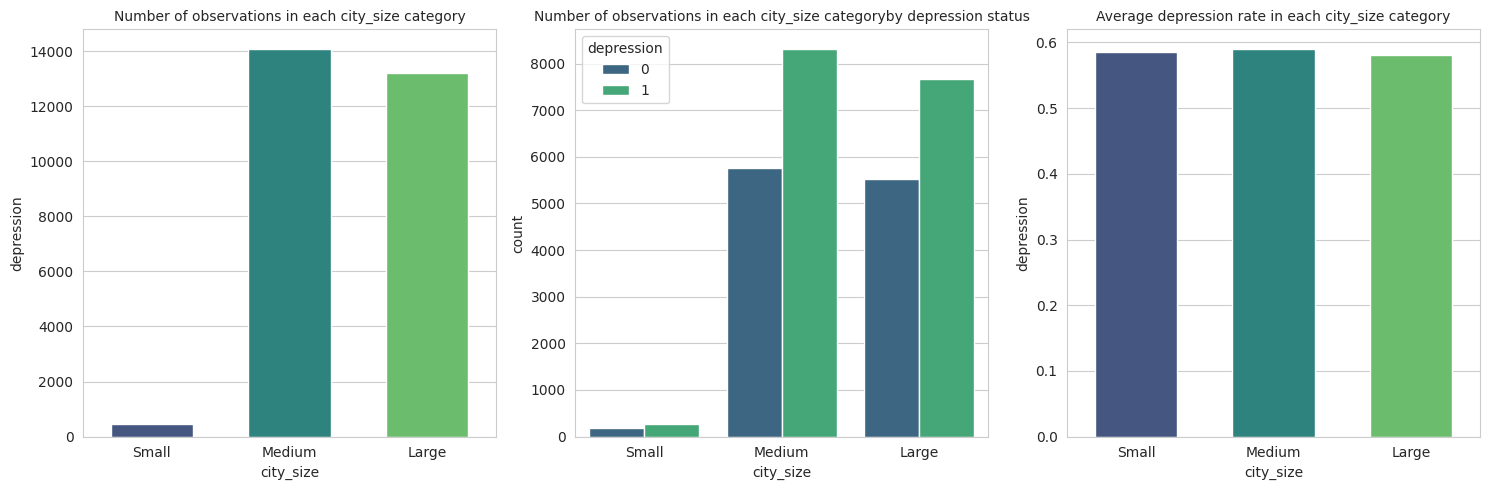

In [45]:
create_plots(feature='city_size', target='depression')

**Chi-Square Test**

In [46]:
chi_test_results('city_size')

Chi-square p-value: 0.32707201970506855
Is there a statistically significant relationship between the variables? no


**ANOVA Test**

In [47]:
anova_test_results('city_size')

ANOVA p-value: 0.3270968170573756
Is there a statistically significant difference between the groups? no


**Conclusion**<br>After segmenting based on city population size, we observe an uneven distribution of samples across the groups. Despite this imbalance, the average proportion of individuals with depression remains relatively consistent across all groups, suggesting that city population size may not be a strong differentiating factor for this target variable.



#### **III. Segmentation Based on Quantile-Based Binning** 

In [48]:
# groups cities into 5 quantile-based categories based on their frequency
city_counts = df['city'].value_counts()
df['city_q'] = pd.qcut(df['city'].map(city_counts).sort_values(), q=5, labels=[1, 2, 3, 4, 5])

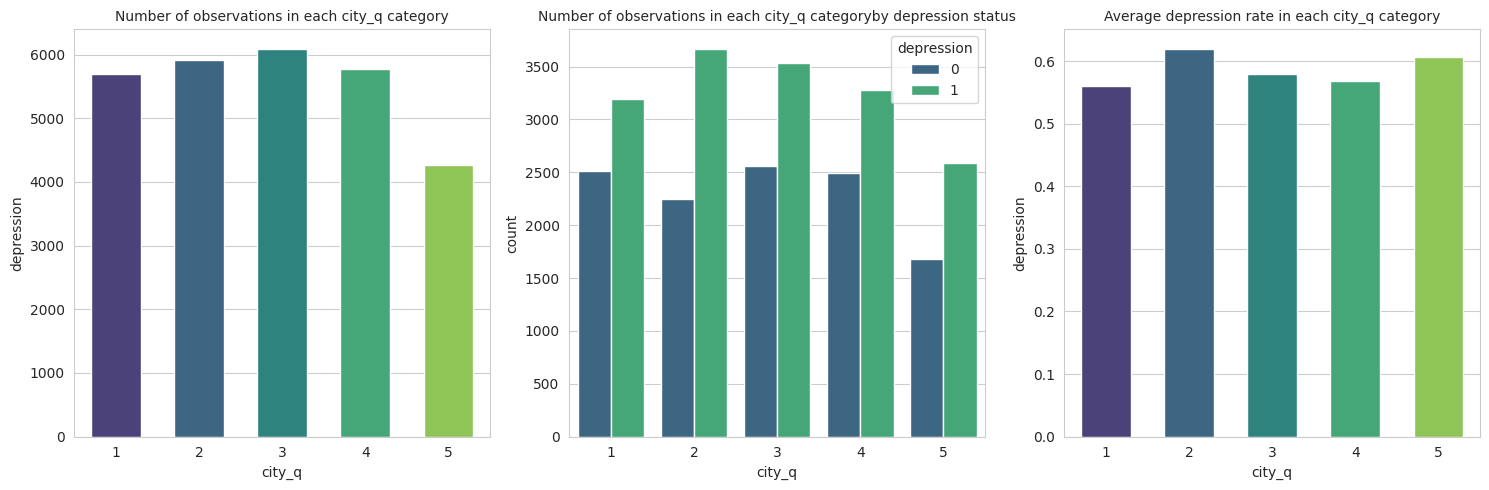

In [49]:
create_plots(feature='city_q', target='depression')

**Chi-Square Test**

In [50]:
chi_test_results('city_q')

Chi-square p-value: 2.66165153403465e-12
Is there a statistically significant relationship between the variables? yes


**ANOVA Test**

In [51]:
anova_test_results('city_q')

ANOVA p-value: 2.589662322472582e-12
Is there a statistically significant difference between the groups? yes


### **Optimal Binning for CGPA Feature**

In [52]:
# create 'cgpa_category' column by categorizing 'cgpa' into intervals
df['cgpa_category'] = pd.Categorical(pd.cut(df['cgpa'], 
                                            bins=[5., 6., 7., 8., 9., 10.],
                                            labels=['Average', 'Above Average', 
                                                    'Good', 'Very Good', 'Excellent']),
                                     ordered=True)

df[['cgpa', 'cgpa_category']].head()

,cgpa,cgpa_category
0,8.97,Very Good
1,5.90,Average
2,7.03,Good
3,5.59,Average
4,8.13,Very Good


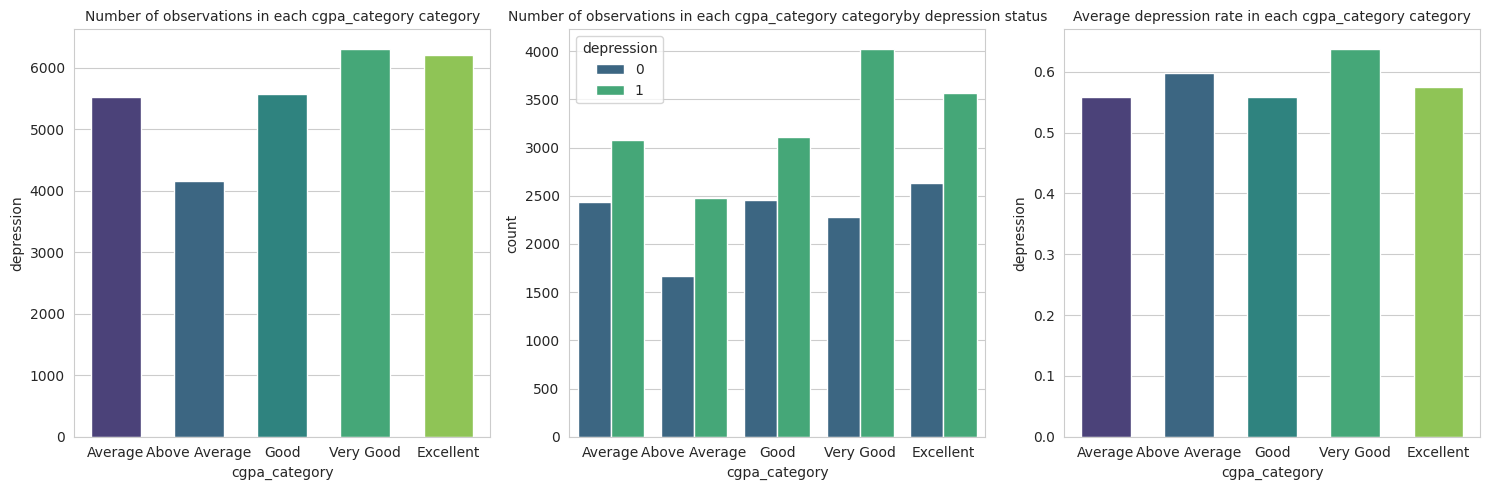

In [53]:
create_plots(feature='cgpa_category', target='depression')

**Chi-Square Test**

In [54]:
chi_test_results('cgpa_category')

Chi-square p-value: 4.449131519684426e-23
Is there a statistically significant relationship between the variables? yes


**ANOVA Test**

In [55]:
anova_test_results('cgpa_category')

ANOVA p-value: 4.01987660940072e-23
Is there a statistically significant difference between the groups? yes


### **Optimal Binning for Age Feature**

In [56]:
# change type in the 'age' column 
df['age'] = df['age'].astype('int')

# create 'age_group' column by categorizing 'age' into intervals
df['age_group'] = pd.Categorical(pd.cut(df['age'], 
                                        bins=[17, 21, 25, 29, 34],
                                        labels=['18-21', '22-25', '26-29', '30-34'],
                                        right=True),
                                 ordered=True)

df[['age', 'age_group']].head()

,age,age_group
0,33,30-34
1,24,22-25
2,31,30-34
3,28,26-29
4,25,22-25


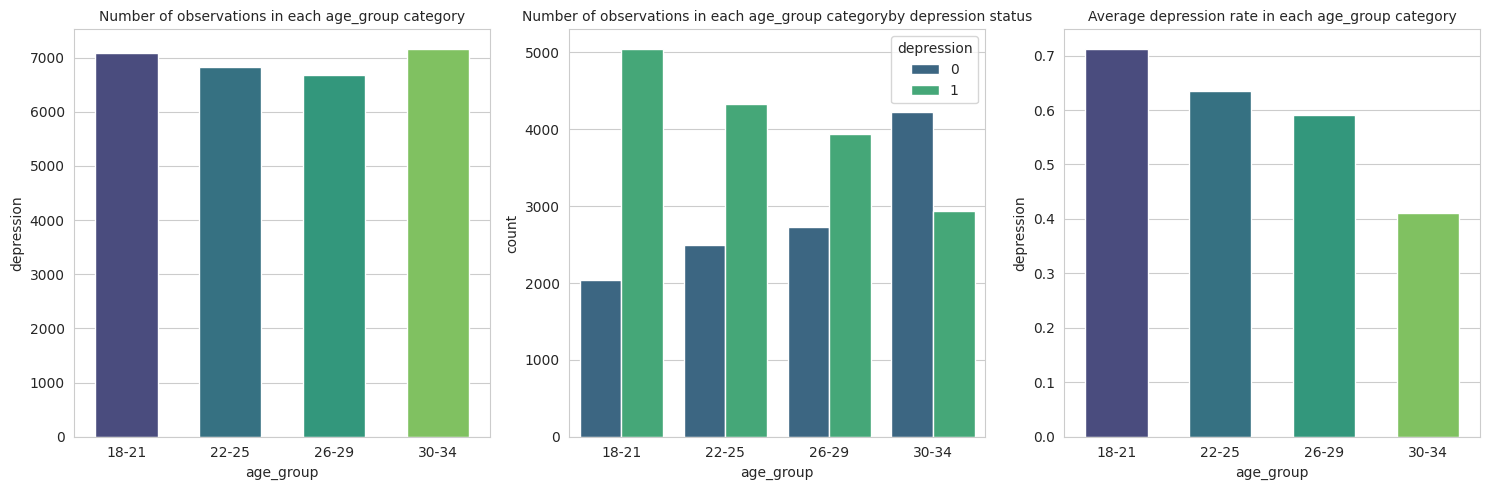

In [57]:
create_plots(feature='age_group', target='depression')

**Chi-Square Test**

In [58]:
chi_test_results('age_group')

Chi-square p-value: 0.0
Is there a statistically significant relationship between the variables? yes


**ANOVA Test**

In [59]:
anova_test_results('age_group')

ANOVA p-value: 2.08e-322
Is there a statistically significant difference between the groups? yes


### **Optimal Binning for Degree Feature**

In [60]:
# create the 'degree_level' column by categorizing 'degree' into intervals
def categorize_degree(degree):
    if degree.startswith('M') or degree.startswith('P') or degree == 'LLM':
        return 'Master and Higher'
    elif degree.startswith('B') or degree == 'LLB':
        return 'Bachelor'
    return 'Secondary Level'

df['degree_level'] = pd.Categorical(df['degree'].apply(categorize_degree),
                                    categories=['Secondary Level', 'Bachelor', 
                                                'Master and Higher'],
                                    ordered=True)
df[['degree', 'degree_level']].head()

,degree,degree_level
0,B.Pharm,Bachelor
1,BSc,Bachelor
2,BA,Bachelor
3,BCA,Bachelor
4,M.Tech,Master and Higher


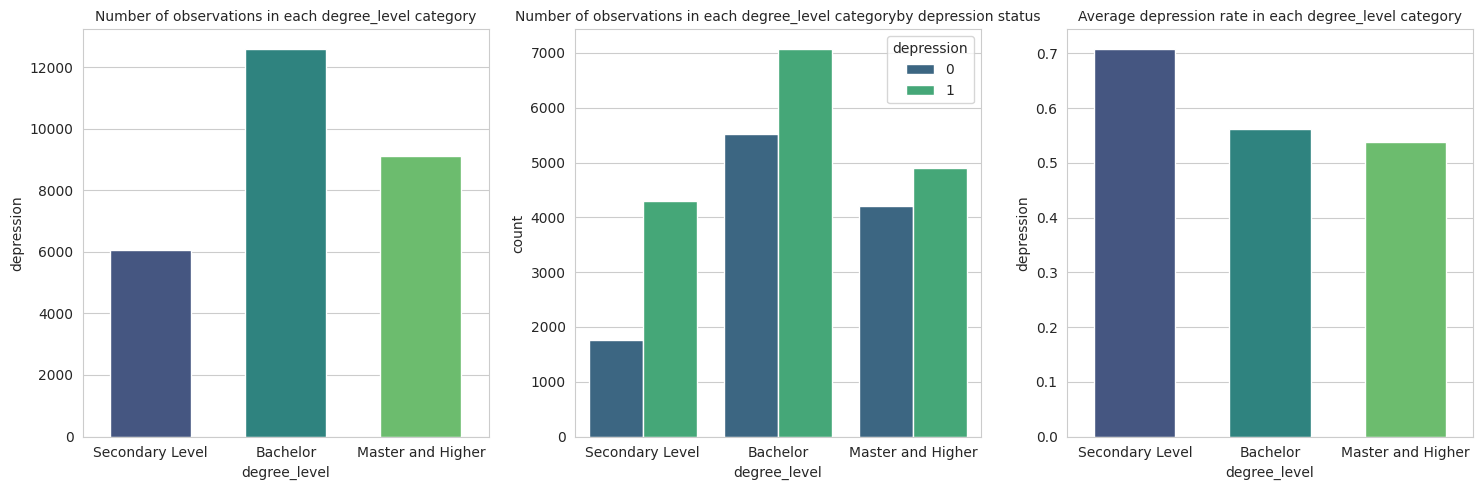

In [61]:
create_plots(feature='degree_level', target='depression')

**Chi-Square Test**

In [62]:
chi_test_results('degree_level')

Chi-square p-value: 1.8803139806968996e-107
Is there a statistically significant relationship between the variables? yes


**ANOVA Test**

In [63]:
anova_test_results('degree_level')

ANOVA p-value: 2.1351687019673177e-108
Is there a statistically significant difference between the groups? yes


**Testing if ordinal encoding of features provides more information to the model compared to One-Hot Encoding**

In [64]:
# set the order for the remaining categorical columns
order_values = {
    'sleep_duration': ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours'],
    'dietary_habits': ['Unhealthy', 'Moderate', 'Healthy'],
}

for key, value in order_values.items():
    df[key] = pd.Categorical(df[key], categories=value, ordered=True)

In [65]:
categorical = ['cgpa_category', 'age_group', 'sleep_duration', 
               'dietary_habits', 'degree_level']

pairs = []
n = 1
for cat in categorical:
    mapping = {value: n + i for i, value in enumerate(df[cat].unique().sort_values())}
    df[f'{cat}_num'] = df[cat].map(mapping)
    pairs.append([cat, f'{cat}_num'])
    n=1

results = []
for cat_feature, num_feature in pairs:
    df_ohe = pd.get_dummies(df[cat_feature], dtype='int')
    mi_ohe = mutual_info_classif(df_ohe, df['depression'])
    mi_ordinal = mutual_info_classif(df[[num_feature]], df['depression'])

    results.append({
        'feature': cat_feature.split('_')[0],
        'category-MI': round(mi_ohe.mean(), 3),
        'numeric-MI': round(mi_ordinal[0], 3)
    })

test_results = pd.DataFrame(results)
test_results

,feature,category-MI,numeric-MI
0,cgpa,0.004,0.002
1,age,0.010,0.034
2,sleep,0.002,0.007
3,dietary,0.010,0.024
4,degree,0.004,0.010


**Conclusion:**<br>After testing the categorical vs. numerical variables, the differences in information gain are minimal.<br>We will proceed with testing both types in the models.

In [66]:
# delete unnecessary columns
df.drop(columns=['city', 'city_size', 'degree'], axis=1, inplace=True)

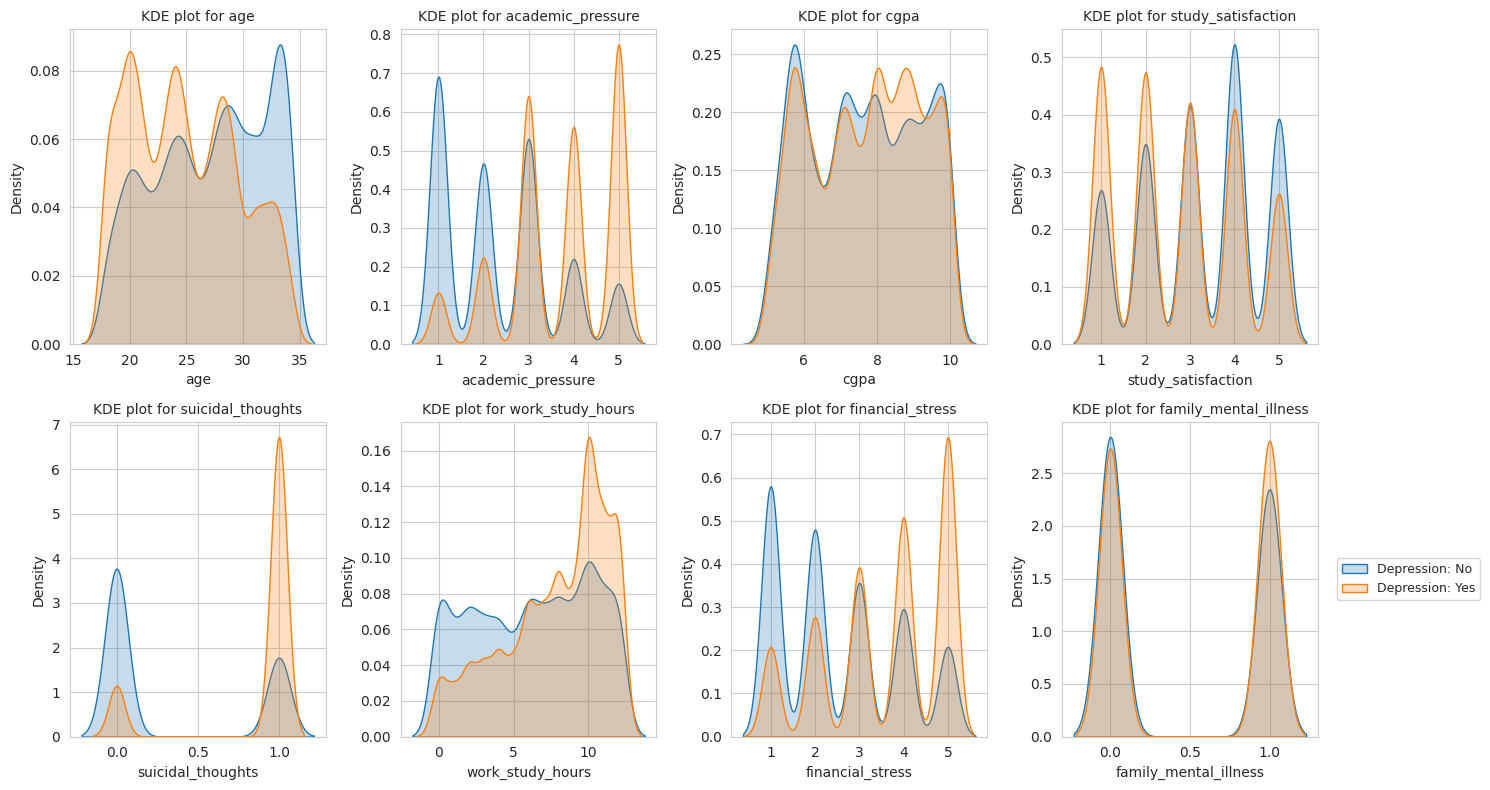

In [67]:
num_features = [
    col for col in df.columns 
    if df[col].dtype in ('float64', 'int64') and col != 'depression'
]

n_cols = 4
n_rows = (len(num_features) + 1) // n_cols  

plt.figure(figsize=(15, 4 * n_rows))  
for i, feature in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)  
    sns.kdeplot(df[df['depression'] == 0][feature], label='Depression: No', shade=True)
    sns.kdeplot(df[df['depression'] == 1][feature], label='Depression: Yes', shade=True)
    plt.title(f'KDE plot for {feature}', fontsize=10)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=9)
plt.tight_layout()
plt.show()

**Conclusion**
1. KDE plots illustrate how the data distribution for different categories of the explanatory variable (feature) differs in relation to the target variable.
2. The distributions for **academic_pressure**, **study_satisfaction**, **suicidal_thoughts**, **work_study_hours**, and **financial_stress** are distinctly separated, suggesting that these features effectively differentiate the target variable.

# **MODELING**

## **Utils**

In [68]:
def run_pipeline(pipeline, param_grid, X_train, X_test, y_train):
    """
    Runs a pipeline with hyperparameter tuning using GridSearchCV.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    y_test_pred =  grid_search.best_estimator_.predict(X_test)
    
    misclassified_metrics(grid_search, X_test, y_test, y_test_pred)
    return y_train_pred, y_test_pred


def get_metrics(y_train, y_test, y_train_pred, y_test_pred):
    """
    Computes performance metrics (F1 score, accuracy, ROC AUC score, and Cohen's kappa) 
    for both train and test sets.
    """
    return pd.DataFrame({
        'dataset': ['train', 'test'],
        'f1': [f1_score(y_train, y_train_pred), 
               f1_score(y_test, y_test_pred)],
        'accuracy': [accuracy_score(y_train, y_train_pred), 
                     accuracy_score(y_test, y_test_pred)],
        'roc_auc_score': [roc_auc_score(y_train, y_train_pred), 
                          roc_auc_score(y_test, y_test_pred)],
        'cohen_kappa': [cohen_kappa_score(y_train, y_train_pred), 
                        cohen_kappa_score(y_test, y_test_pred)]
    }).set_index('dataset')


def create_cm_plot(y_test, y_test_pred):
    """
    Creates and displays a confusion matrix heatmap.
    """
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
                annot=True, 
                fmt='d', 
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()


def misclassified_metrics(grid_search, X_test, y_test, y_test_pred):
    """
    Analyzes misclassified samples based on model confidence.
    """
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
    
    sorted_probas = np.sort(y_pred_proba, axis=1)
    max_proba = sorted_probas[:, -1]  
    second_max_proba = sorted_probas[:, -2] 
    confidence_margin = max_proba - second_max_proba  

    misclassified = y_test != y_test_pred

    high_confidence_errors = misclassified & (max_proba > 0.8)
    low_confidence_errors = misclassified & (confidence_margin <= 0.05)
    print(f'\nNumber of high confidence errors (>80% certainty): {high_confidence_errors.sum()}')
    print(f'Number of low confidence errors (<=5% certainty): {low_confidence_errors.sum()}\n')


--------------------------------------------------------------------------------------

In [69]:
X = df.drop('depression', axis=1)
y = df['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [70]:
# top-performing features for prediction in each model
model_features = {
    'knn': {
        'cat': ['sleep_duration', 'degree_level', 'dietary_habits', 'cgpa_category', 
                'age_group'],
        
        'num': ['academic_pressure', 'study_satisfaction', 'work_study_hours', 
                'financial_stress'],
        
        'bin': ['suicidal_thoughts']
    },
    'lr': {
        'cat': ['sleep_duration', 'dietary_habits', 'cgpa_category'],
        
        'num': ['academic_pressure', 'study_satisfaction', 'work_study_hours', 
                'financial_stress'],
        
        'bin': ['suicidal_thoughts'] 
    },
    'rf': {
        'cat': ['sleep_duration', 'cgpa_category', 'degree_level'],
        
        'rest': ['academic_pressure', 'study_satisfaction', 'suicidal_thoughts', 
                 'work_study_hours', 'financial_stress', 'age_group_num', 
                 'dietary_habits_num']
    },
    'gb': {
        'cat': ['gender', 'sleep_duration', 'dietary_habits', 'cgpa_category', 
                'age_group', 'degree_level'],
        
        'rest': ['age', 'academic_pressure', 'cgpa', 'study_satisfaction', 
                 'suicidal_thoughts', 'work_study_hours', 'financial_stress', 
                 'family_mental_illness', 'city_q',  'cgpa_category_num', 'age_group_num', 
                 'sleep_duration_num', 'dietary_habits_num', 'degree_level_num']
    }
}

## **KNeighborsClassifier**


Number of high confidence errors (>80% certainty): 236
Number of low confidence errors (<=5% certainty): 0



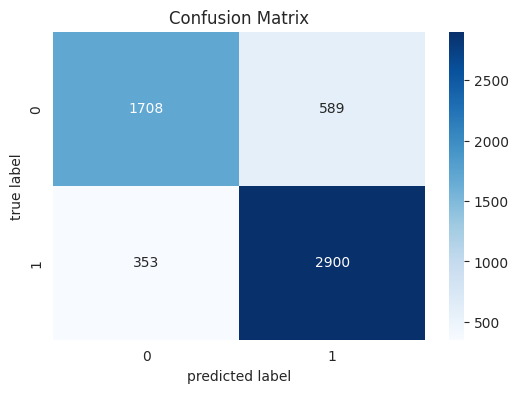

,f1,accuracy,roc_auc_score,cohen_kappa
dataset,,,,
train,0.876348,0.85027,0.838824,0.687092
test,0.860279,0.83027,0.817532,0.644798


In [71]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(
        drop='first', 
        sparse_output=False, 
        handle_unknown='ignore'
    ), model_features['knn']['cat']),
    
    ('num', StandardScaler(),  model_features['knn']['num']),
    ('bin', 'passthrough',  model_features['knn']['bin'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [7, 11, 13],
    'model__weights': ['distance', 'uniform']
}

y_train_pred, y_test_pred = run_pipeline(pipeline, param_grid, X_train, X_test, y_train)
create_cm_plot(y_test, y_test_pred)
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

## **LogisticRegression**


Number of high confidence errors (>80% certainty): 257
Number of low confidence errors (<=5% certainty): 60



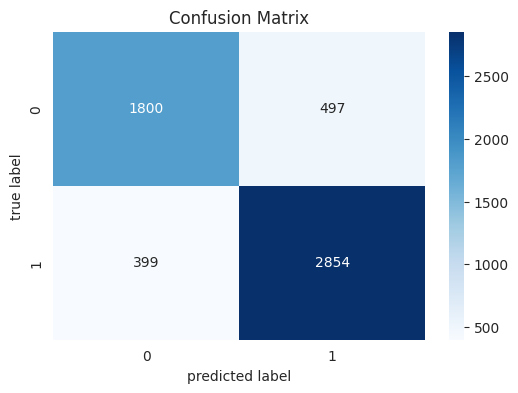

,f1,accuracy,roc_auc_score,cohen_kappa
dataset,,,,
train,0.865398,0.839054,0.829958,0.665479
test,0.864325,0.838559,0.830487,0.665145


In [72]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(
        drop='first', 
        sparse_output=False, 
        handle_unknown='ignore'
    ), model_features['lr']['cat']),
    
    ('num', StandardScaler(), model_features['lr']['num']),
    ('bin', 'passthrough', model_features['lr']['bin'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])

param_grid = {
    'model__penalty': [None, 'l2', 'l1'], 
    'model__C': [0.5, 1, 1.5, 2],
    'model__class_weight': [None, 'balanced'],    
}

y_train_pred, y_test_pred = run_pipeline(pipeline, param_grid, X_train, X_test, y_train)
create_cm_plot(y_test, y_test_pred)
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

## **RandomForestClassifier**


Number of high confidence errors (>80% certainty): 135
Number of low confidence errors (<=5% certainty): 115



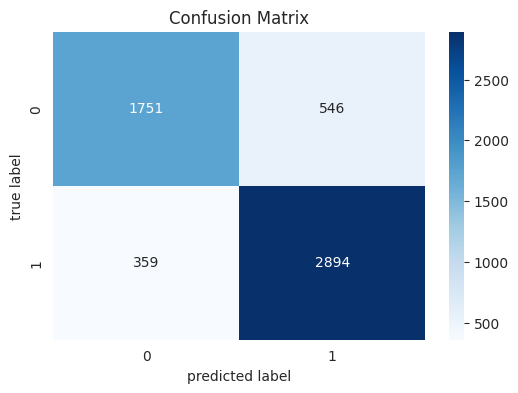

,f1,accuracy,roc_auc_score,cohen_kappa
dataset,,,,
train,0.870929,0.843964,0.832676,0.674146
test,0.864784,0.836937,0.825969,0.659832


In [73]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), model_features['rf']['cat']),
    ('rest', 'passthrough', model_features['rf']['rest'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [20, 30],
    'model__min_samples_leaf': [10, 15]
}

y_train_pred, y_test_pred = run_pipeline(pipeline, param_grid, X_train, X_test, y_train)
create_cm_plot(y_test, y_test_pred)
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

## **GradientBoostingClassifier**


Number of high confidence errors (>80% certainty): 291
Number of low confidence errors (<=5% certainty): 49



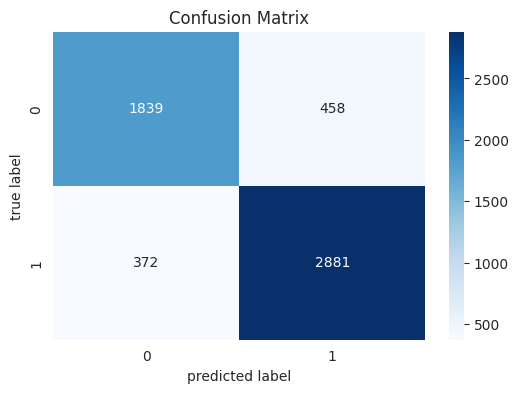

,f1,accuracy,roc_auc_score,cohen_kappa
dataset,,,,
train,0.883258,0.860946,0.853334,0.711455
test,0.874090,0.850450,0.843127,0.690050


In [74]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), model_features['gb']['cat']),
    ('rest', 'passthrough', model_features['gb']['rest'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])

param_grid = {
    'model__n_estimators': [100, 150, 200], 
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],  
    'model__max_depth': [3, 5, 7],  
}

y_train_pred, y_test_pred = run_pipeline(pipeline, param_grid, X_train, X_test, y_train)
create_cm_plot(y_test, y_test_pred)
get_metrics(y_train, y_test, y_train_pred, y_test_pred)